<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#SECTION-1:-Data-Analysis-and-Preprocessing" data-toc-modified-id="SECTION-1:-Data-Analysis-and-Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>SECTION 1: Data Analysis and Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Read-FHV-Csv-File" data-toc-modified-id="Read-FHV-Csv-File-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Read FHV Csv File</a></span></li><li><span><a href="#Prepare-External-Features" data-toc-modified-id="Prepare-External-Features-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Prepare External Features</a></span></li><li><span><a href="#Data-Visualization" data-toc-modified-id="Data-Visualization-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Data Visualization</a></span></li></ul></li><li><span><a href="#SECTION-2:-Seasonal-ARIMA-Model" data-toc-modified-id="SECTION-2:-Seasonal-ARIMA-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>SECTION 2: Seasonal ARIMA Model</a></span><ul class="toc-item"><li><span><a href="#Select-Parameters" data-toc-modified-id="Select-Parameters-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Select Parameters</a></span><ul class="toc-item"><li><span><a href="#Is-the-Data-Stationary?" data-toc-modified-id="Is-the-Data-Stationary?-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Is the Data Stationary?</a></span></li><li><span><a href="#Making-Data-Stationary-by-Moving-Average,-Differencing..." data-toc-modified-id="Making-Data-Stationary-by-Moving-Average,-Differencing...-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Making Data Stationary by Moving Average, Differencing...</a></span></li><li><span><a href="#Picking-Model-Parameters-p,-d,-q" data-toc-modified-id="Picking-Model-Parameters-p,-d,-q-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Picking Model Parameters p, d, q</a></span></li></ul></li><li><span><a href="#Time-Series-Prediction" data-toc-modified-id="Time-Series-Prediction-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Time Series Prediction</a></span><ul class="toc-item"><li><span><a href="#Train-and-Test-Data-Splitting" data-toc-modified-id="Train-and-Test-Data-Splitting-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Train and Test Data Splitting</a></span></li><li><span><a href="#Train-Model" data-toc-modified-id="Train-Model-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Train Model</a></span></li><li><span><a href="#Predicting-Test-Data" data-toc-modified-id="Predicting-Test-Data-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Predicting Test Data</a></span></li><li><span><a href="#Evaluation-Metrics" data-toc-modified-id="Evaluation-Metrics-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>Evaluation Metrics</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
import warnings
from datetime import datetime
import holidays

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings("ignore")

# SECTION 1: Data Analysis and Preprocessing

## Data Introduction

The dataset used for time-series prediction is New York daily traffic trips from year 2015 to mid 2018. Trip records in late 2018 are dropped due to two obvious spikes, the two outliers can be replaced by mean value to get more data. However, since the purpose of this project is to compare the performance of LSTM and traditional SARIMA model on time-series prediction, data in late 2018 are therefore not considered. 

The For-Hire Vehicle (“FHV”) trip records are used for the present work, which include fields capturing the dispatching base license number and the pick-up date, time, and taxi zone location ID. 

## Read FHV Data

In [2]:
workdir = "./"

In [3]:
filename = workdir + "FHV_NY_tripdata_2015to2018.csv"
df = pd.read_csv(filename)

In [4]:
print(df.shape)
df.head()

(1463, 2)


,Date,Trips
0,2015-01-01,77789
1,2015-01-02,61832
2,2015-01-03,81955
3,2015-01-04,62691
4,2015-01-05,71063


## Data Visualization 

[Text(0, 0.5, 'number of trips'),
 Text(0.5, 0, 'date'),
 Text(0.5, 1.0, '2015-2018')]

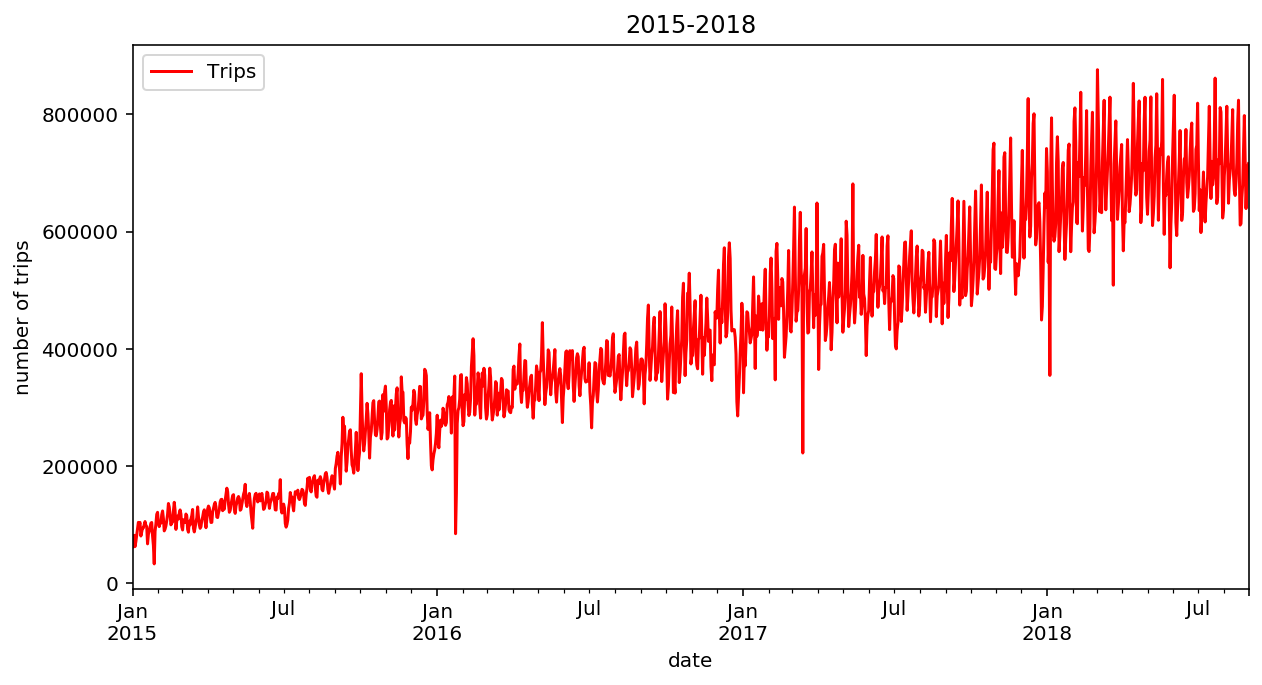

In [5]:
df = df.iloc[:-125]
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
ax = df.plot(x='Date', y='Trips', kind='line', figsize=(10, 5), style=['red'], 
             marker='', linewidth=1.5, fontsize=10)
ax.set(xlabel='date', ylabel='number of trips', title='2015-2018')

1. <b> very clear upwards trend is found during this period, which means the data is not stationary </b>
2. <b> irregular spikes are also observed, nonlinear behaviors cannot be processed by linear model </b>

# SECTION 2: Seasonal ARIMA Model

## Select Parameters
### Is the Data Stationary?

Data is stationary if its mean, variance remain constant over time, i.e., no trend or seasonality

<b>Dickey Fuller test -- to determine "d"</b>
1. Null hypothesis H0: Time series is non stationary
2. Altenate hypothesis H1: if test statics < critical value reject H0

<b>ACF and PACF plots -- to determine "p" and "q"</b>
stationary time series will show a quick drop-off in correlation

In [9]:
def dickey_fuller(timeseries):
    print("Results of Dickey-Fuller Test:")
    test = adfuller(timeseries, autolag = 'AIC')
    output = pd.Series(test[0:4], 
                       index = ['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    
    for k, v in test[4].items():
        output['Critical Value {}'.format(k)] = v
        output['stationary {}'.format(k)] = 'False' if v < test[0] else 'True'
        
    print(output)
    return

In [10]:
def decompose(timeseries):
    """
    decomposition of seasonal time series
    """
    decomposition = seasonal_decompose(timeseries)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    fig, ax = plt.subplots(3, figsize=(9, 9))
    ax[0].plot(trend, label='Trend')
    ax[0].legend(loc='best')
    ax[1].plot(seasonal,label='Seasonality')
    ax[1].legend(loc='best')
    ax[2].plot(residual, label='Residuals')
    ax[2].legend(loc='best')
    plt.tight_layout()
    fig.autofmt_xdate()
    
    return trend , seasonal, residual

In [11]:
def plot_acf_pacf(data):
    fig, ax = plt.subplots(3, figsize=(9,9))
    ax[0].plot(data)
    ax[1] = plot_acf(data, ax = ax[1], lags = 20)
    ax[2] = plot_pacf(data, ax = ax[2], lags = 20)
    plt.tight_layout()

In [12]:
data = df[['Date', 'Trips']]
data.set_index('Date', inplace=True)

data.head()

,Trips
Date,
2015-01-01,77789
2015-01-02,61832
2015-01-03,81955
2015-01-04,62691
2015-01-05,71063


### Making Data Stationary by Moving Average, Differencing...

In [13]:
# check raw data
dickey_fuller(data)

Results of Dickey-Fuller Test:
Test Statistic                -0.822071
p-value                        0.812553
Lags Used                            23
Number of Observations Used        1314
Critical Value 1%              -3.43534
stationary 1%                     False
Critical Value 5%              -2.86374
stationary 5%                     False
Critical Value 10%             -2.56794
stationary 10%                    False
dtype: object


<b> First, check raw data -- not stationary </b>

In [14]:
# check log(raw data)
dickey_fuller(np.log(data))

Results of Dickey-Fuller Test:
Test Statistic                 -2.70684
p-value                        0.072862
Lags Used                            21
Number of Observations Used        1316
Critical Value 1%              -3.43533
stationary 1%                     False
Critical Value 5%              -2.86374
stationary 5%                     False
Critical Value 10%             -2.56794
stationary 10%                     True
dtype: object


<b> Second, check log(Raw data) -- stationary 10% confidence level, could be better </b>

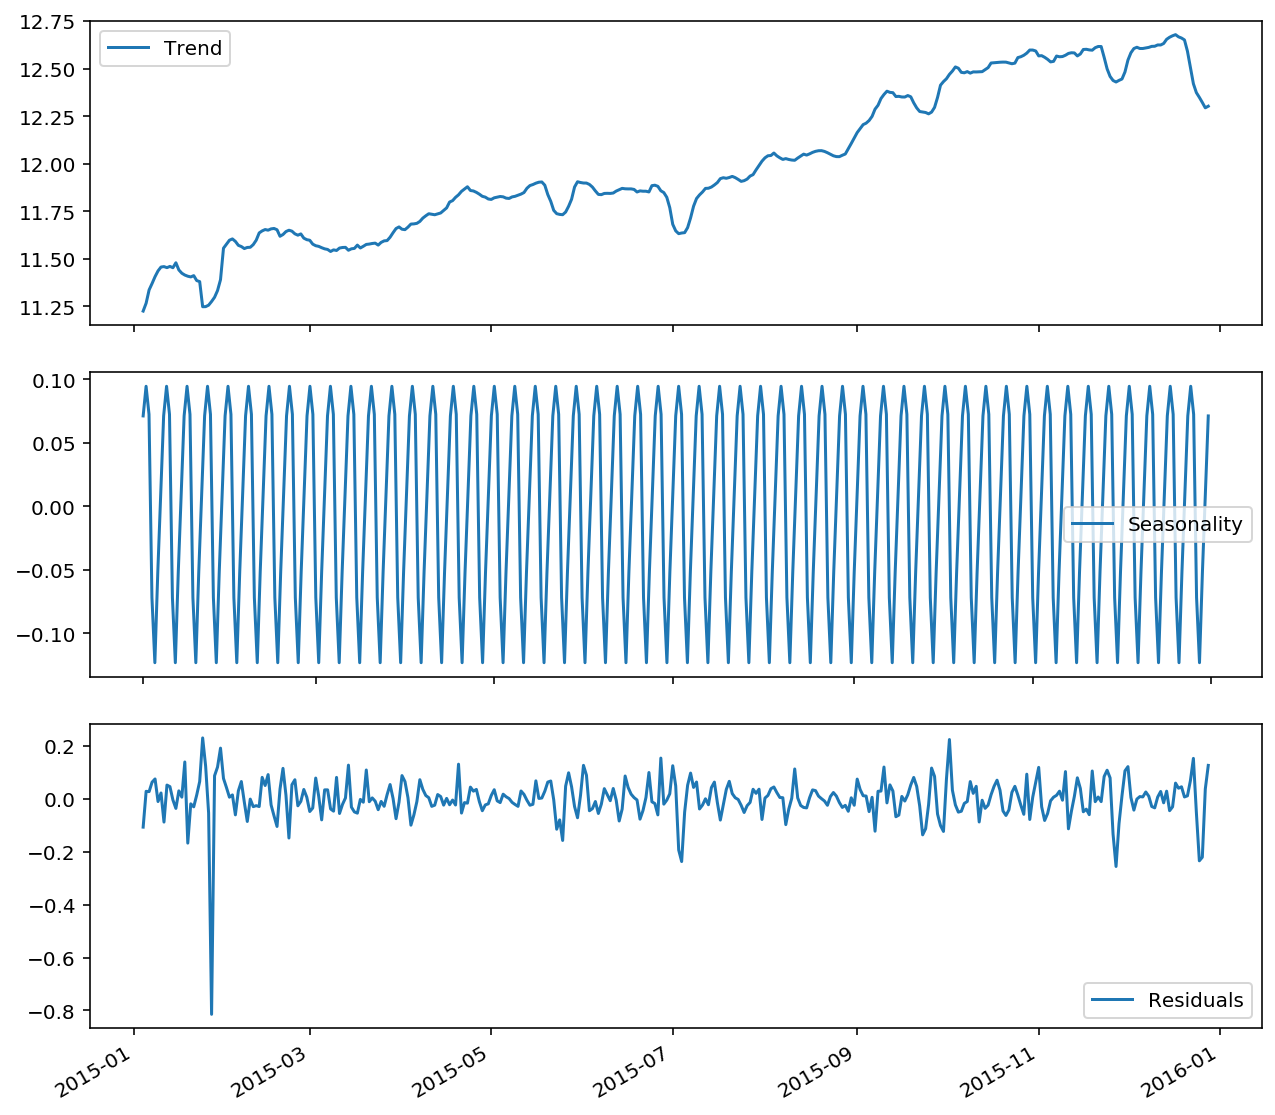

In [15]:
# check seasonality log(raw data)
trend, seasonal, residual = decompose(np.log(data.iloc[:365]))

<b> Third, check seasonality, found 7-day period </b>

In [16]:
# check raw - 7-day moving average
data['rolling'] = data['Trips'].rolling(7).mean()
data['raw_ma'] = data['Trips'] - data['rolling']
dickey_fuller(data['raw_ma'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                    -13.0469
p-value                        2.18264e-24
Lags Used                               22
Number of Observations Used           1309
Critical Value 1%                 -3.43536
stationary 1%                         True
Critical Value 5%                 -2.86375
stationary 5%                         True
Critical Value 10%                -2.56795
stationary 10%                        True
dtype: object


<B> Fourth, check data substracting 7-day moving average -- stationary, well done! </b>

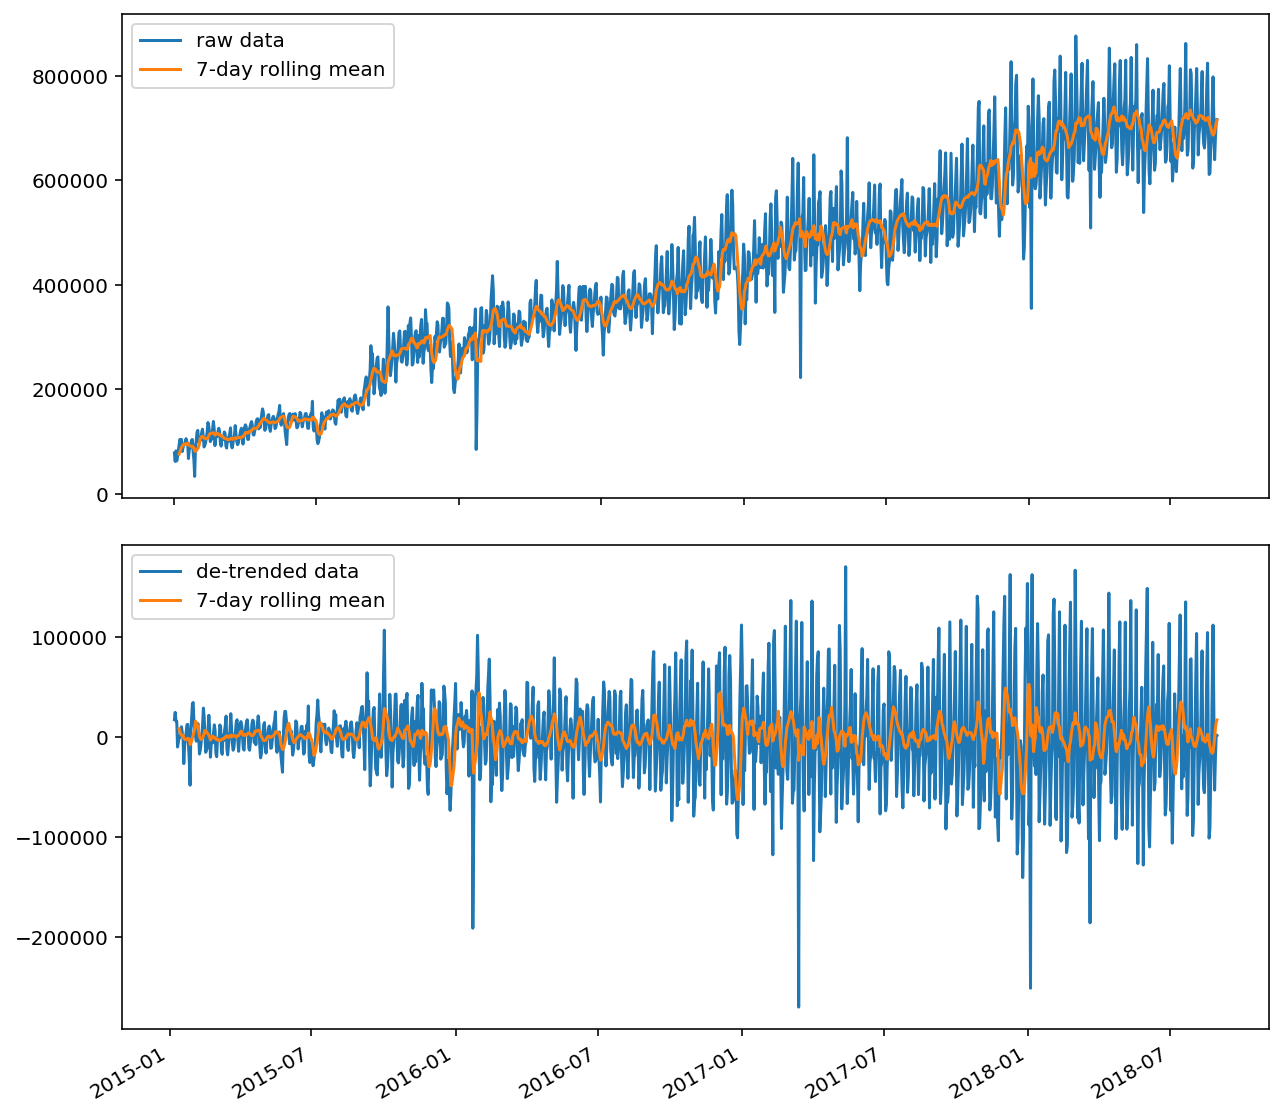

In [17]:
fig, ax = plt.subplots(2, figsize=(9, 9))
ax[0].plot(data.index, data['Trips'], label='raw data')
ax[0].plot(data['rolling'], label="7-day rolling mean");
ax[0].legend()

ax[1].plot(data.index, data['raw_ma'], label="de-trended data")
ax[1].plot(data['raw_ma'].rolling(window=7).mean(), label="7-day rolling mean");
ax[1].legend()

plt.tight_layout()
fig.autofmt_xdate()

<b> NOTE: skip smoothing model check </b>

1. Smoothing method is used to give more weight to most recent data, and reduce the effect of previous records
2. With/without smoothing model doesn't affect model performance too much, so skipped here

test with Holt-Winter’s Seasonal Smoothing model under the tsa package

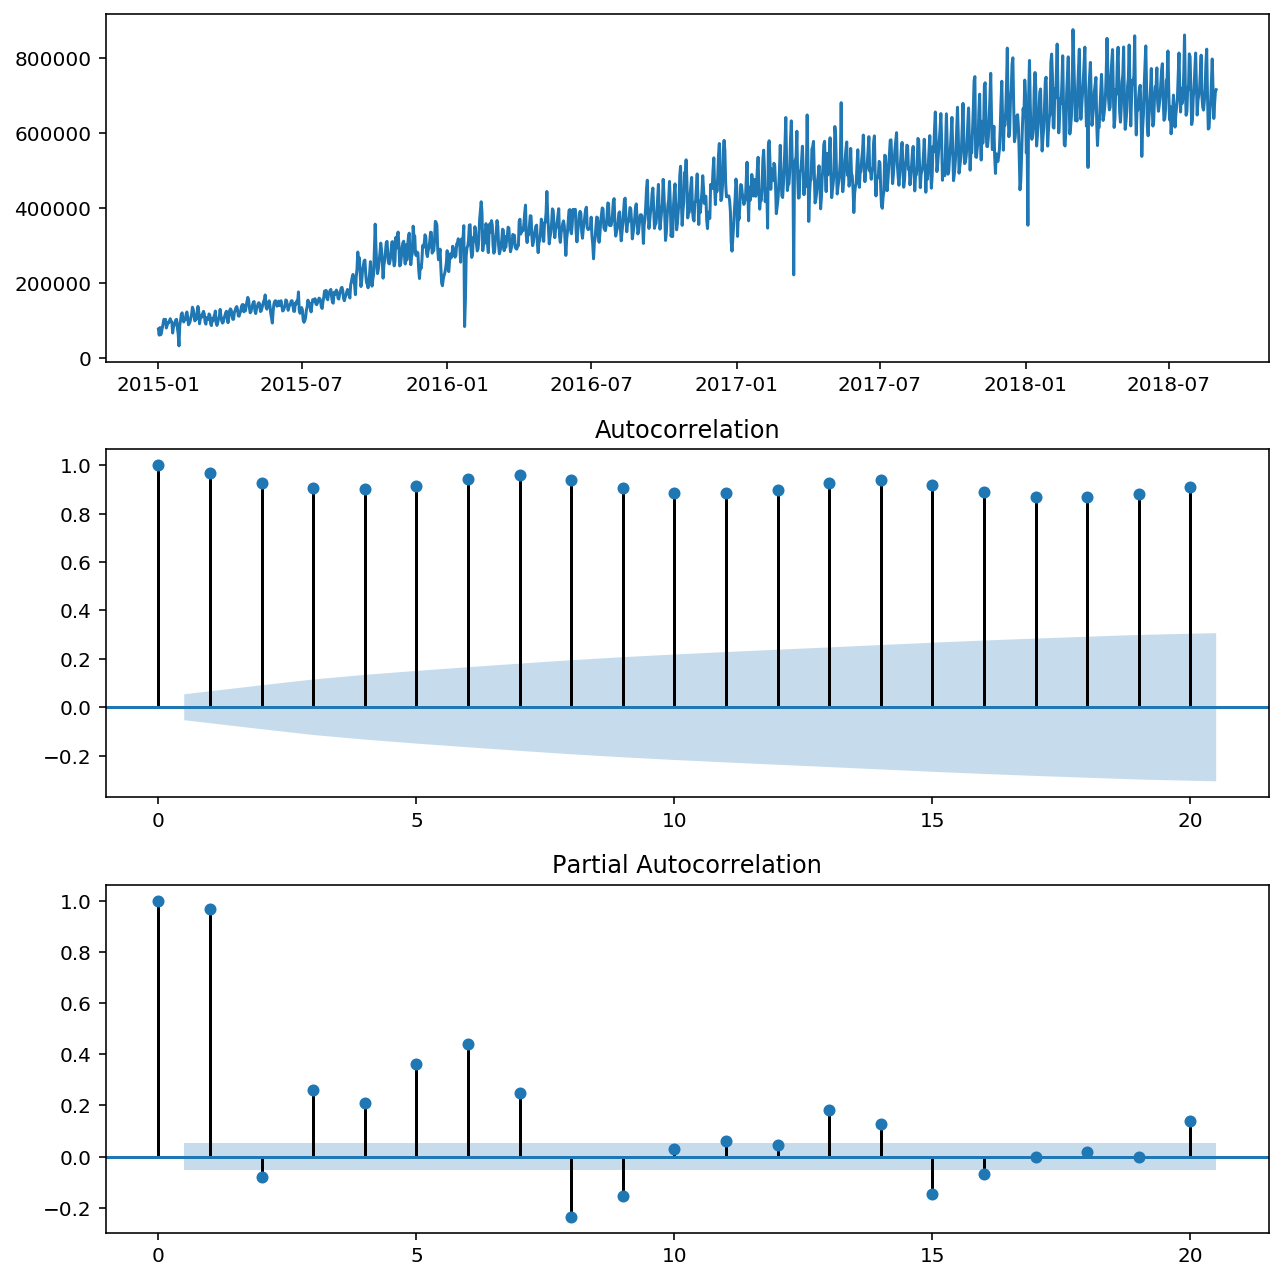

In [18]:
# plot raw, acf, pacf
plot_acf_pacf(data['Trips'])

<b> raw data is not stationary, so not good </b>

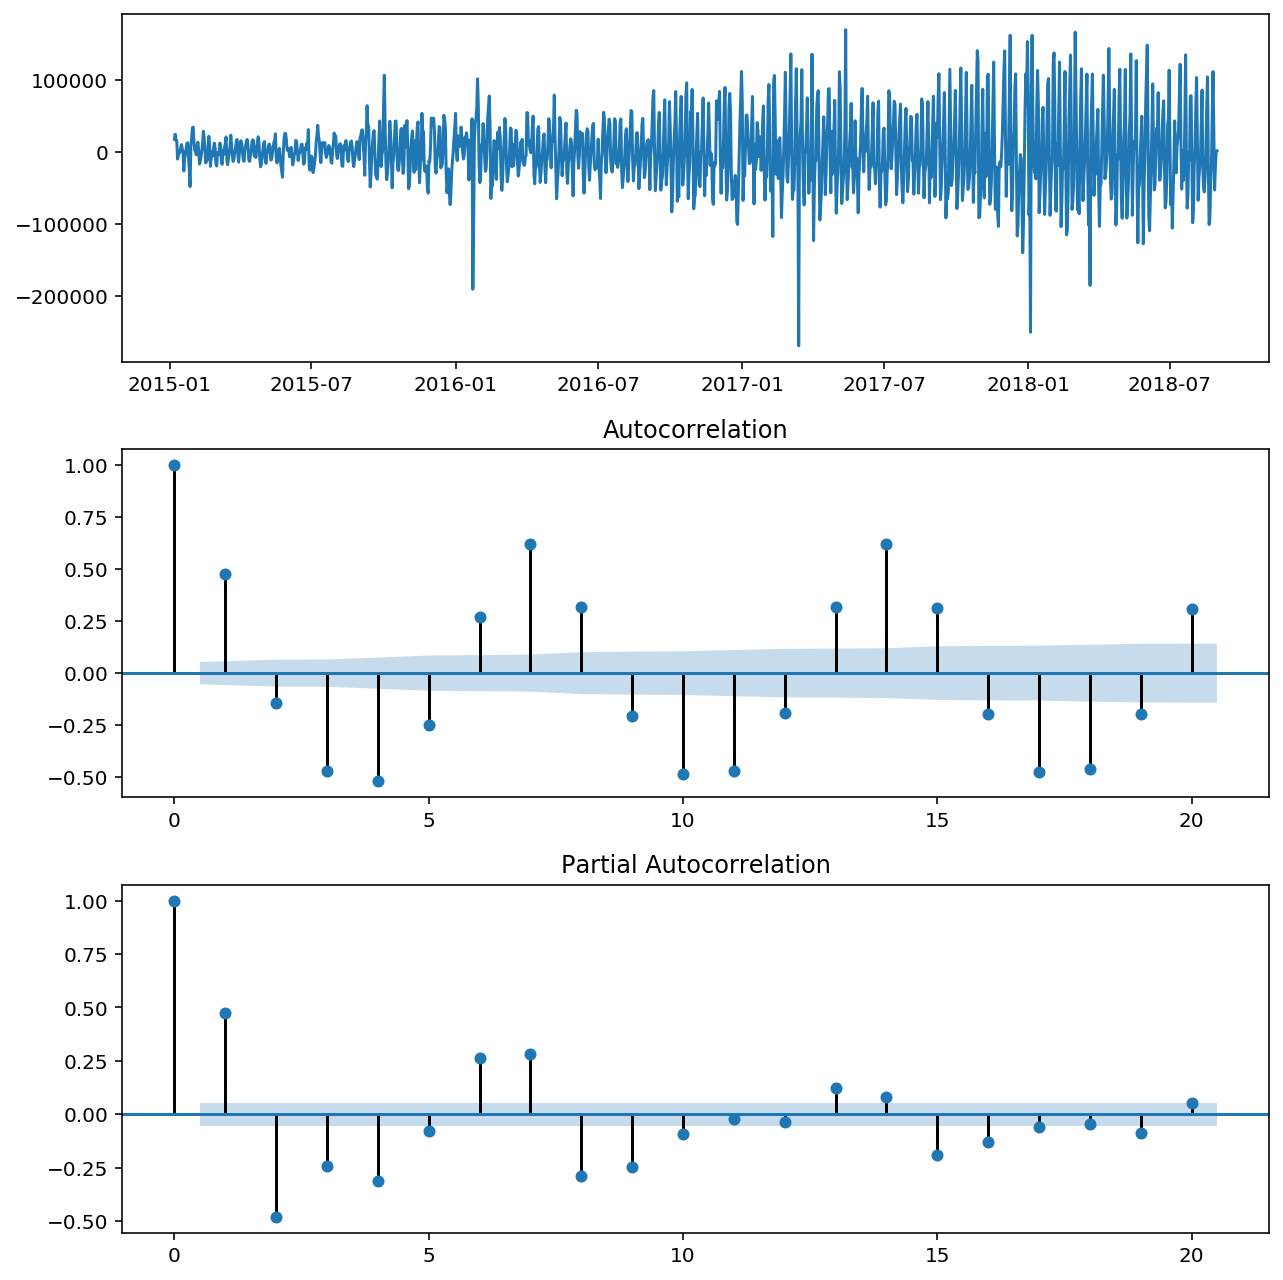

In [19]:
# plot stationary data with 7-day sliding window
plot_acf_pacf(data['raw_ma'].dropna())

<b> although detrend data is stationary, still not good, need differencing </b>

### Picking Model Parameters p, d, q 


<b> Number of AR (Auto-Regressive) terms (p):</b><br> p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

<b> Number of Differences (d):</b><br> d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.

<b> Number of MA (Moving Average) terms (q):</b><br> q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

<b> P, D and Q should also be picked for seasonal AMRIA model </b>

## Time Series Prediction
### Train and Test Data Splitting

<b> data in 2015-2017 are traing data, 2018 are testing data </b>

In [20]:
split_date = datetime.strptime('2018-01-01', '%Y-%m-%d')

train = data['raw_ma'].iloc[data.index < split_date]
test = data['raw_ma'].iloc[data.index >= split_date]

train = train.dropna()
test = test.dropna()

train.shape, test.shape

((1090,), (242,))

### Train Model

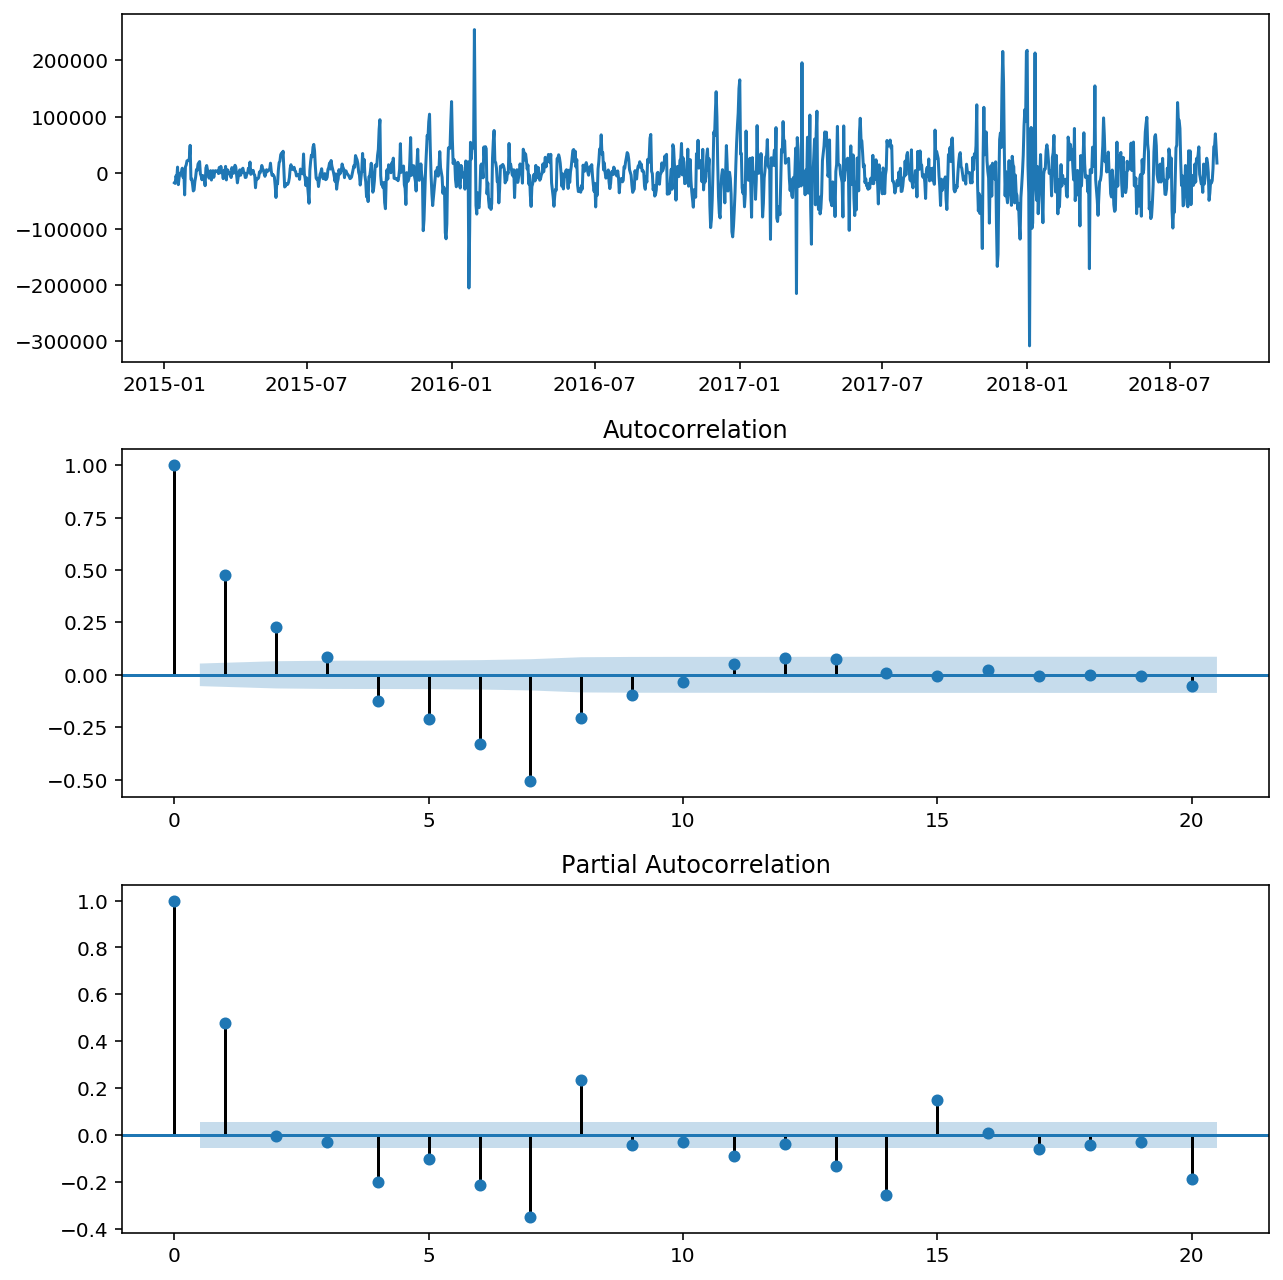

In [21]:
# first order differencing of stationary data
x = data['raw_ma'].dropna() - data['raw_ma'].dropna().shift(7)
plot_acf_pacf(x.dropna())

<b>(p, d, q) of (2, 1, 1) with 7 days cycle is a good choice.</b>

<b> NOTE: AIC is a valuable criterion to determine these parameters if GridSearch is used.</b>

In [22]:
model = sm.tsa.statespace.SARIMAX(train, order=(2, 1, 1), seasonal_order=(2, 1, 1, 7), 
                                  enforce_invertibility=False, enforce_stationarity=False)
model_fit = model.fit()

In [23]:
model_fit.summary() # check AIC, p values

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            raw_ma   No. Observations:                 1090
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 7)   Log Likelihood              -12455.058
Date:                           Sat, 21 Nov 2020   AIC                          24924.117
Time:                                   16:53:05   BIC                          24958.919
Sample:                               01-07-2015   HQIC                         24937.303
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4799      0.028     16.982      0.000       0.424       0.535
ar.L2         -0.0585      0.047     -1.243      0.214      -0.151       0.034
ma.L1         -0.9969      0.015    -68.554      0.000      -1.025      -0.968
ar.S.L7        0.0041      0.068      0.060      0.952      -0.129       0.137
ar.S.L14      -0.0281      0.066     -0.425      0.671      -0.158       0.102
ma.S.L7       -0.9136      0.029    -31.909      0.000      -0.970      -0.858
sigma2      1.379e+09   1.61e-11   8.55e+19      0.000    1.38e+09    1.38e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             14921.56
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               5.40   Skew:                            -1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.27e+35. Standard errors may be unstable.
"""

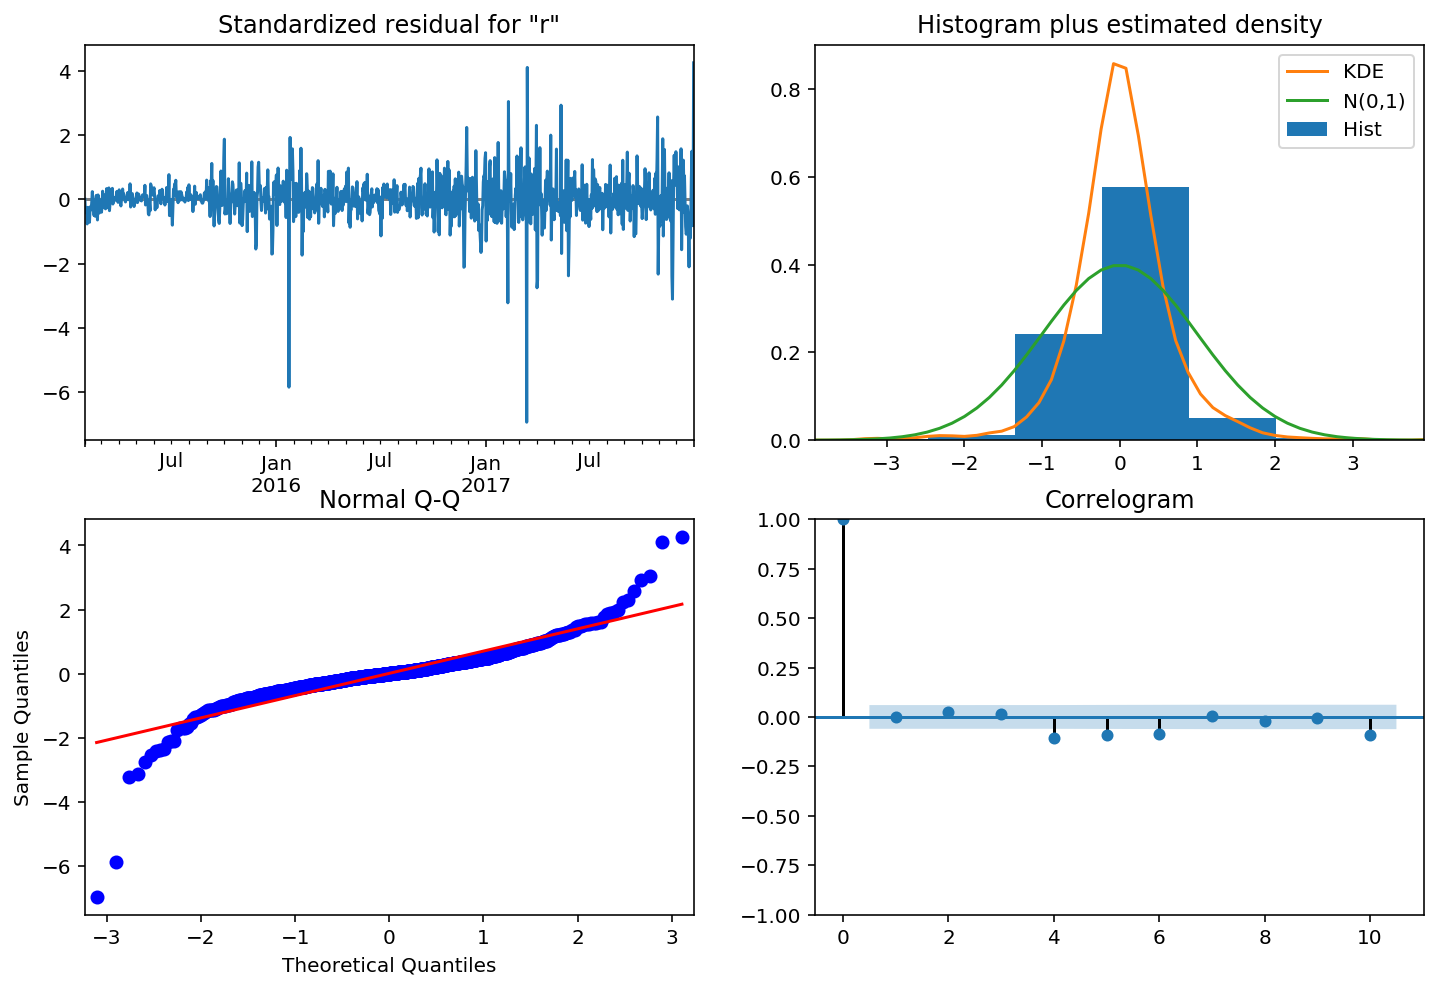

In [24]:
diagnostic_plot = model_fit.plot_diagnostics(figsize = (12, 8)) # good 

### Predicting Test Data

In [25]:
pred = model_fit.get_prediction(start = test.index[0].strftime('%Y-%m-%d'),
                                end = test.index[-1].strftime('%Y-%m-%d'))

pred.predicted_mean.shape

(242,)

In [26]:
idx = test.shape[0] + 7

rolling_back = df['Trips'].iloc[-idx:-1].rolling(7).mean()

fc = pred.predicted_mean + rolling_back.dropna().values
conf = pred.conf_int(alpha=0.05)

lower_bounds = conf.iloc[:, 0] + rolling_back.dropna().values
upper_bounds = conf.iloc[:, 1] + rolling_back.dropna().values

rmse_ = np.sqrt(np.mean(np.square(test.values - pred.predicted_mean.values)))

Text(0.5, 1.0, 'SARIMA')

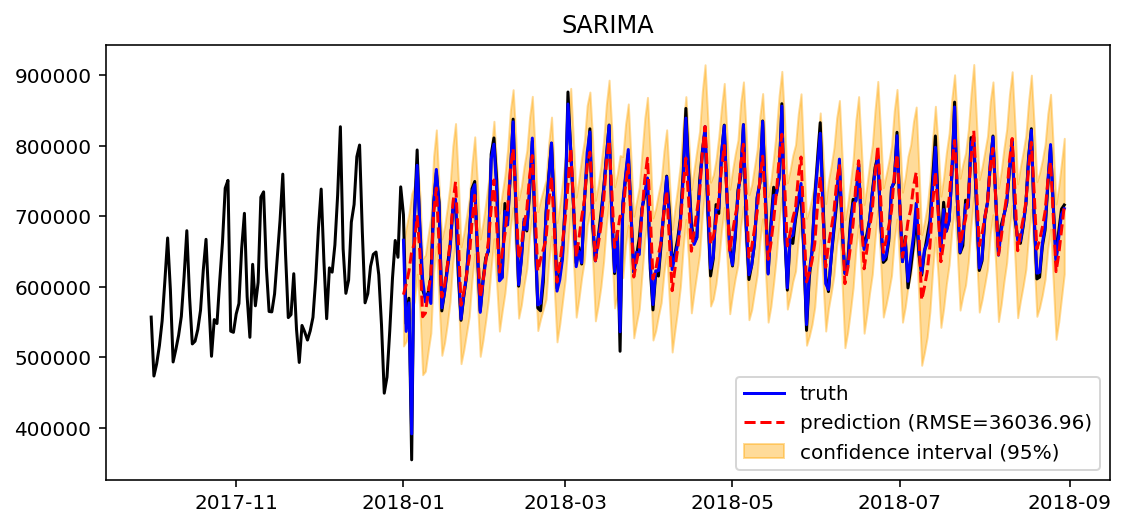

In [27]:
fig, ax = plt.subplots(figsize=(9, 4))

ax.plot(data.loc[data.index >= datetime.strptime('2017-10-01', '%Y-%m-%d'), 'Trips'].index, 
        data.loc[data.index >= datetime.strptime('2017-10-01', '%Y-%m-%d'), 'Trips'].values, 
        color='black')
ax.plot(test.index, test.values + rolling_back.dropna().values, 
        color='blue', label='truth')
ax.plot(test.index, fc, color='red', linestyle='--', 
        label="prediction (RMSE={:0.2f})".format(rmse_))
ax.fill_between(test.index, lower_bounds, upper_bounds, 
                color='orange', alpha=0.4, label="confidence interval (95%)")

ax.legend()
ax.set_title("SARIMA")

### Evaluation Metrics
<b> R Squared </b> <br>
coefficient of determination (percentage of variance explained by the model), (-inf, 1]

<b> Mean Absolute Error </b> <br>
it is an interpretable metric, which has the same unit of measurement as the initial series, [0, +inf)

<b> Median Absolute Error </b> <br>
interpretable metric, robust to outliers, [0, +inf)

<b> Mean Squared Error </b> <br>
gives higher penalty to big mistakes and vise versa, [0, +inf)

<b> Mean Squared Logarithmic Error </b> <br>
practically the same as MSE but we initially take logarithm of the series, as a result we give attention to small mistakes as well, usually is used when data has exponential trends, [0, +inf)

<b> Mean Absolute Percentage Error </b> <br>
same as MAE but percentage, — very convenient when you want to explain the quality of the model to your management, [0, +inf),

In [28]:
def evaluate_metrics(y, pred):
    results = pd.DataFrame({'r2_score': r2_score(y, pred)}, index=[0])
    results['Mean_Absolute_Error'] = mean_absolute_error(y, pred)
    results['Median_Absolute_Error'] = median_absolute_error(y, pred)
    results['MSE'] = mean_squared_error(y, pred)
    results['MSLE'] = mean_squared_log_error(y, pred)
    results['MAPE'] = np.mean(np.abs((y - pred) / y)) * 100
    results['RMSE'] = np.sqrt(results['MSE'])
    return results

In [29]:
evaluation = evaluate_metrics(test.values + rolling_back.dropna().values, fc)
evaluation

,r2_score,Mean_Absolute_Error,Median_Absolute_Error,MSE,MSLE,MAPE,RMSE
0,0.744579,25507.152305,20877.574473,1.298663e+09,0.003303,3.865081,36036.964473


# SECTION 3: Brief Conclusion Between LSTM and SARIMA

1. <b> LSTM has an overall better performance based on the "evaluation" table </b>

2. <b> LSTM can deal with nonlinear problems (spikes are well captured in LSTM), in this case, the extreme weather events and holidays </b>
3. <b> LSTM gives a narrower confidence interval</b>
4. <b> LSTM is best for long-term predictions </b>